In [8]:
import numpy as np
import torch

In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook
from PIL import Image
from sklearn import metrics


train_acl = pd.read_csv('data/MRNet-v1.0/train-acl.csv', header=None,
                       names=['Case', 'Class'], 
                       dtype={'Case': str, 'Class': np.int64})

In [9]:
train_acl.head()

,Case,Class
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


In [10]:
print(train_acl.shape)

(1130, 2)


In [11]:
train_acl.Class.value_counts()

Class
0    922
1    208
Name: count, dtype: int64

In [63]:
from PIL import Image

In [1]:
import torch
import numpy as np
sample_path = "data/MRNet-v1.0/2131.npy"
knee_image_0 = np.load(sample_path)

In [5]:
knee_image_0

44

In [10]:
np.ones(knee_image_0.shape[0]).shape

(44,)

In [13]:
torch.squeeze(knee_image_0.float(), dim=0).shape

AttributeError: 'numpy.ndarray' object has no attribute 'float'

In [ ]:
np.stack((knee_image_0,)*3, axis=1)

In [14]:
np.expand_dims(np.stack((knee_image_0,)*3, axis=1)[0], axis=0).shape

(1, 3, 256, 256)

In [21]:
import numpy as np
sample_path = "data/MRNet-v1.0/2131.npy"
knee_image_0 = np.load(sample_path)[6]
np.expand_dims(knee_image_0, axis=0).shape

(1, 256, 256)

In [85]:
slice_index = 5
axis = 0
slice_2d = knee_image_0.take(indices=slice_index, axis=axis)

array = Image.fromarray(slice_2d).resize((224, 224), Image.BILINEAR)
array = np.array(array)
array = np.expand_dims(array, axis=2)
array = np.repeat(array, 3, axis=2)

In [86]:
import matplotlib.pyplot as plt

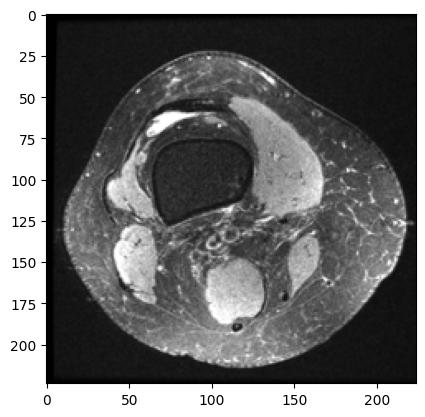

In [87]:
plt.imshow(array, cmap='gray')

In [88]:
array.shape

(224, 224, 3)

In [93]:
torch.squeeze(torch.FloatTensor(array)).shape

torch.Size([224, 224, 3])

In [26]:
import torch

In [30]:
# torch.squeeze(knee_image_0, dim=0).view(torch.squeeze(knee_image_0, dim=0).size(0), -1).shape
torch.max(torch.squeeze(knee_image_0, dim=0).view(torch.squeeze(knee_image_0, dim=0).size(0), -1),dim=0,keepdim=True)[0].shape

torch.Size([1, 65536])

In [40]:
torch.squeeze(knee_image_0, dim=0).view(torch.squeeze(knee_image_0, dim=0).size(0), -1).shape

torch.Size([44, 65536])

In [42]:
slice_index = 5
axis = 0
slice_2d = knee_image_0.take(indices=slice_index, axis=axis)

In [51]:
torch.squeeze(knee_image_0, dim=0).shape

torch.Size([44, 256, 256])

In [32]:
pad = int((knee_image_0.shape[2] - 224)/2)
        # This is equivalent to center cropping the image
image = knee_image_0[:,pad:-pad,pad:-pad]

In [36]:
np.stack((image,)*3, axis=1).shape

(44, 3, 224, 224)

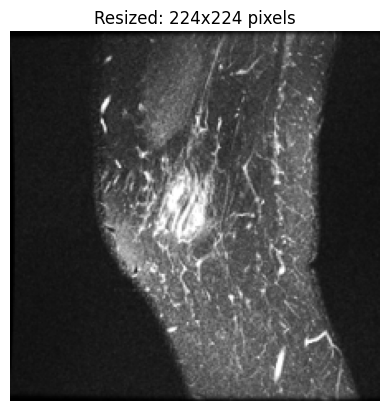

In [21]:
# Select the desired slice from the 3D image (similar to the previous example)
slice_index = 5
axis = 0
slice_2d = knee_image_0.take(indices=slice_index, axis=axis)

# Resize the 2D slice to 224x224 pixels
resized_slice = Image.fromarray(slice_2d).resize((224, 224), Image.BILINEAR)

# Get the dimensions (length and width) of the resized slice
length = resized_slice.size[0]
width = resized_slice.size[1]

# Display the resized 2D slice along with its dimensions
plt.imshow(resized_slice, cmap='gray')
plt.axis('off')
plt.title(f"Resized: {length}x{width} pixels")
plt.show()

In [47]:
knee_image_0.shape[0]

36

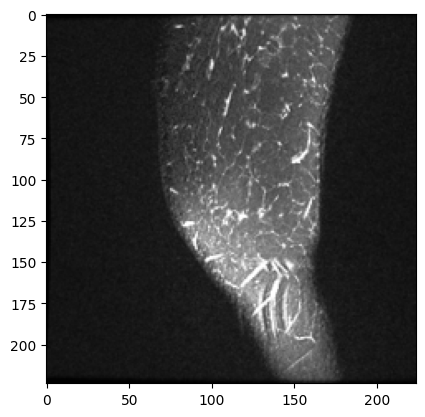

In [49]:
for i in range(knee_image_0.shape[0]):
    plt.imshow(Image.fromarray(knee_image_0[i].astype(np.uint8)).resize((224, 224), Image.BILINEAR), cmap='gray')
    plt.show()
    break

In [53]:
from PIL import Image
import torch.utils.data as data
class MRdataset(data.Dataset):
    def __init__(self, root, class_types=['acl'],planes=['sagittal'], train=True, transforms=None): 
        super().__init__()
        # location of the dataset
        self.root = root
        # list of classes
        self.class_types = class_types
        # transforms
        self.transforms = transforms
        
        # Define the three planes to use
        self.planes=planes

        self.root = root
        self.train = train

        self.records = None

        self.image_path = {}

        #made for only one plane and one class type needs to update for all 

        if self.train:
            for plane in self.planes:
                self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            for _ in class_types:
                self.records = pd.read_csv(
                    self.root + 'train-{0}.csv'.format(_), header=None,
                        names=['Case', 'Class'], 
                        dtype={'Case': str, 'Class': np.int64})
       
        else:
            transform = None
            for plane in self.planes:
                self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            for _ in class_types:
                self.records = pd.read_csv(
                    self.root + 'valid-{0}.csv'.format(_), header=None,
                        names=['Case', 'Class'], 
                        dtype={'Case': str, 'Class': np.int64})
                

        self.paths={}
        for plane in self.planes:
            # Get paths of numpy data files for each plane
            self.paths[plane] = [self.image_path[plane] + filename +
                          '.npy' for filename in self.records['Case'].tolist()]
            
        
        # Convert labels from Pandas Series to a list
        self.labels = self.records['Class'].tolist()


    def __getitem__(self, item):
        # read the image
        array = np.load(self.paths[item])
        # class for that image
        label = self.labels[item]
        label = torch.FloatTensor([label])


        """Resize the image to `(3,224,224)` and apply 
        transforms if possible.
        """
        INPUT_DIM = 224
        # Resize the image
        # Calculate extra padding present in the image
        # which needs to be removed
        pad = int((array.shape[2] - INPUT_DIM)/2)
        # This is equivalent to center cropping the image
        array = array[:,pad:-pad,pad:-pad]
        # # Normalize the image by subtracting it by mean and dividing by standard
        # # deviation
        # image = (image-np.min(image))/(np.max(image)-np.min(image))*MAX_PIXEL_VAL
        # image = (image - MEAN) / STDDEV



        # apply transformation
        if self.transform:
            image = self.transform(array)
        else:
            array = np.stack((array,)*3, axis=1)
            image = torch.FloatTensor(array)
        # return the image and class
        return image, label

    def __len__(self):
        # return the total number of images
        return len(self.records)

In [ ]:
def _train_model(model, train_loader, epoch, num_epochs, optimizer, criterion, writer, current_lr, log_every=100):
    
    # Set to train mode
    model.train()

    # Initialize the predicted probabilities
    y_probs = []
    # Initialize the groundtruth labels
    y_gt = []
    # Initialize the loss between the groundtruth label
    # and the predicted probability
    losses = []

    # Iterate over the training dataset
    for i, (images, label) in enumerate(train_loader):
        # Reset the gradient by zeroing it
        optimizer.zero_grad()
        
        # If GPU is available, transfer the images and label
        # to the GPU
        if torch.cuda.is_available():
            images = [image.cuda() for image in images]
            label = label.cuda()

        # Obtain the prediction using the model
        output = model(images)

        # Evaluate the loss by comparing the prediction
        # and groundtruth label
        loss = criterion(output, label)
        # Perform a backward propagation
        loss.backward()
        # Modify the weights based on the error gradient
        optimizer.step()

        # Add current loss to the list of losses
        loss_value = loss.item()
        losses.append(loss_value)

        # Find probabilities from output using sigmoid function
        probas = torch.sigmoid(output)

        # Add current groundtruth label to the list of groundtruths
        y_gt.append(int(label.item()))
        # Add current probabilities to the list of probabilities
        y_probs.append(probas.item())

        try:
            # Try finding the area under ROC curve
            auc = metrics.roc_auc_score(y_gt, y_probs)
        except:
            # Use default value of area under ROC curve as 0.5
            auc = 0.5
        
        # Add information to the writer about training loss and Area under ROC curve
        writer.add_scalar('Train/Loss', loss_value,
                          epoch * len(train_loader) + i)
        writer.add_scalar('Train/AUC', auc, epoch * len(train_loader) + i)

        if (i % log_every == 0) & (i > 0):
            # Display the information about average training loss and area under ROC curve
            print('''[Epoch: {0} / {1} | Batch : {2} / {3} ]| Avg Train Loss {4} | Train AUC : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(train_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )
    # Add information to the writer about total epochs and Area under ROC curve
    writer.add_scalar('Train/AUC_epoch', auc, epoch + i)

    # Find mean area under ROC curve and training loss
    train_loss_epoch = np.round(np.mean(losses), 4)
    train_auc_epoch = np.round(auc, 4)

    return train_loss_epoch, train_auc_epoch